In [97]:
import numpy as np
import pandas as pd
import pymysql

In [98]:
def connect_to_db():
    try:
        connection = pymysql.connect(
            host='127.0.0.1',
            user='root',
            password='el89829603',
            database='finvision',
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        print("連線成功")
        return connection
    except pymysql.MySQLError as e:
        print(f"帳密或資料庫、伺服器輸入錯誤: {e}")
        return None

In [99]:
def execute_sql(connection, query):
    try:
        with connection.cursor() as cursor:
            if query.strip():  # 確保語句不為空
                cursor.execute(query)
                result = cursor.fetchall()
            return result
    except pymysql.MySQLError as e:
        return f"SQL query error: {e}"
    finally:
        if connection and connection.open:
            connection.close()

In [100]:
def get_data(column_name: str):
    sql_query = f'''
        SELECT seasons, {column_name}
        FROM (
            SELECT seasons, {column_name}
            FROM indicators
            ORDER BY seasons DESC
            LIMIT 20
        ) sub
        ORDER BY seasons ASC;
    '''
    
    connection = connect_to_db()
    if connection:
        result = execute_sql(connection, sql_query)
        return result
    else:
        return "Database connection failed"

In [101]:
def get_column_name(index_data):
    if isinstance(index_data, list) and len(index_data) > 0:
        # 從第一個字典中獲取所有 key
        data_dict = index_data[0]
        # 使用列表推導式來過濾 key
        keys = [key for key in data_dict.keys() if key != 'seasons']
        return keys
    else:
        return []

In [102]:
def create_control_charts(index_data):
    """
    為每個欄位創建管制圖數據
    
    Args:
        index_data: 輸入數據
    Returns:
        dict: 每個欄位的管制圖數據
    """
    columns = get_column_name(index_data)  # 獲取所有欄位名稱
    all_charts = {}
    
    for column_name in columns:
        result = get_data(column_name)
        
        # 轉為 DataFrame
        df = pd.DataFrame(result)
        
        # 設定 EMA 的衰減因子
        span = 3
        
        # 計算指數加權移動平均值和標準差
        df['ema'] = df[column_name].ewm(span=span, adjust=False).mean()
        df['emsd'] = df[column_name].ewm(span=span, adjust=False).std()
        
        # 計算1σ, 2σ 和 3σ (UCL 和 LCL) 控制限
        k = [1, 2, 3]
        for sigma in k:
            df[f'UCL_{sigma}sigma'] = df['ema'] + (sigma * df['emsd'])
            df[f'LCL_{sigma}sigma'] = df['ema'] - (sigma * df['emsd'])
        
        # 移除前兩筆資料
        df = df.iloc[3:]
        
        # 準備每個欄位的結果
        chart_data = df[['seasons', column_name, 'ema', 'emsd', 
                        'UCL_1sigma', 'LCL_1sigma', 
                        'UCL_2sigma', 'LCL_2sigma', 
                        'UCL_3sigma', 'LCL_3sigma']].to_dict('records')
        
        all_charts[column_name] = chart_data
    
    return all_charts

In [103]:
def plot_control_chart(charts_data):
    """
    為所有欄位繪製管制圖並直接顯示
    
    Args:
        charts_data (dict): 包含所有欄位管制圖數據的字典
    """
    import matplotlib.pyplot as plt
    
    # 計算需要的子圖數量
    n_charts = len(charts_data)
    
    # 創建圖表和子圖
    fig, axs = plt.subplots(n_charts, 1, figsize=(12, 5*n_charts))
    if n_charts == 1:
        axs = [axs]
    
    # 設置子圖之間的間距
    plt.subplots_adjust(hspace=0.4)
    
    for idx, (column_name, chart_data) in enumerate(charts_data.items()):
        # 將數據轉換回 DataFrame
        df = pd.DataFrame(chart_data)
        
        # 獲取當前子圖
        ax = axs[idx]
        
        # 繪製原始數據和 EMA
        ax.plot(df['seasons'], df[column_name], 'k.-', label='Raw Data')
        ax.plot(df['seasons'], df['ema'], 'm--', label='EMA')
        
        # 繪製控制限
        # 使用不同顏色的控制線
        control_limits = [
            {'sigma': 3, 'color': 'red', 'style': '-'},
            {'sigma': 2, 'color': 'orange', 'style': ':'},
            {'sigma': 1, 'color': 'green', 'style': ':'}
        ]
        
        for limit in control_limits:
            sigma = limit['sigma']
            color = limit['color']
            style = limit['style']
            
            # 繪製上下限
            ax.plot(df['seasons'], df[f'UCL_{sigma}sigma'], 
                   color=color, linestyle=style, 
                   label=f'+{sigma}σ')
            ax.plot(df['seasons'], df[f'LCL_{sigma}sigma'], 
                   color=color, linestyle=style, 
                   label=f'-{sigma}σ')
        
        # 設置標題和標籤
        ax.set_title(f'Control Chart - {column_name}')
        ax.set_xlabel('Seasons')
        ax.set_ylabel('Value')
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # 旋轉 x 軸標籤以避免重疊
        ax.tick_params(axis='x', rotation=45)
        
        # 添加圖例
        ax.legend()
    
    # 調整布局以確保所有元素都顯示完整
    plt.tight_layout()
    
    # 顯示圖表
    plt.show()

連線成功
連線成功


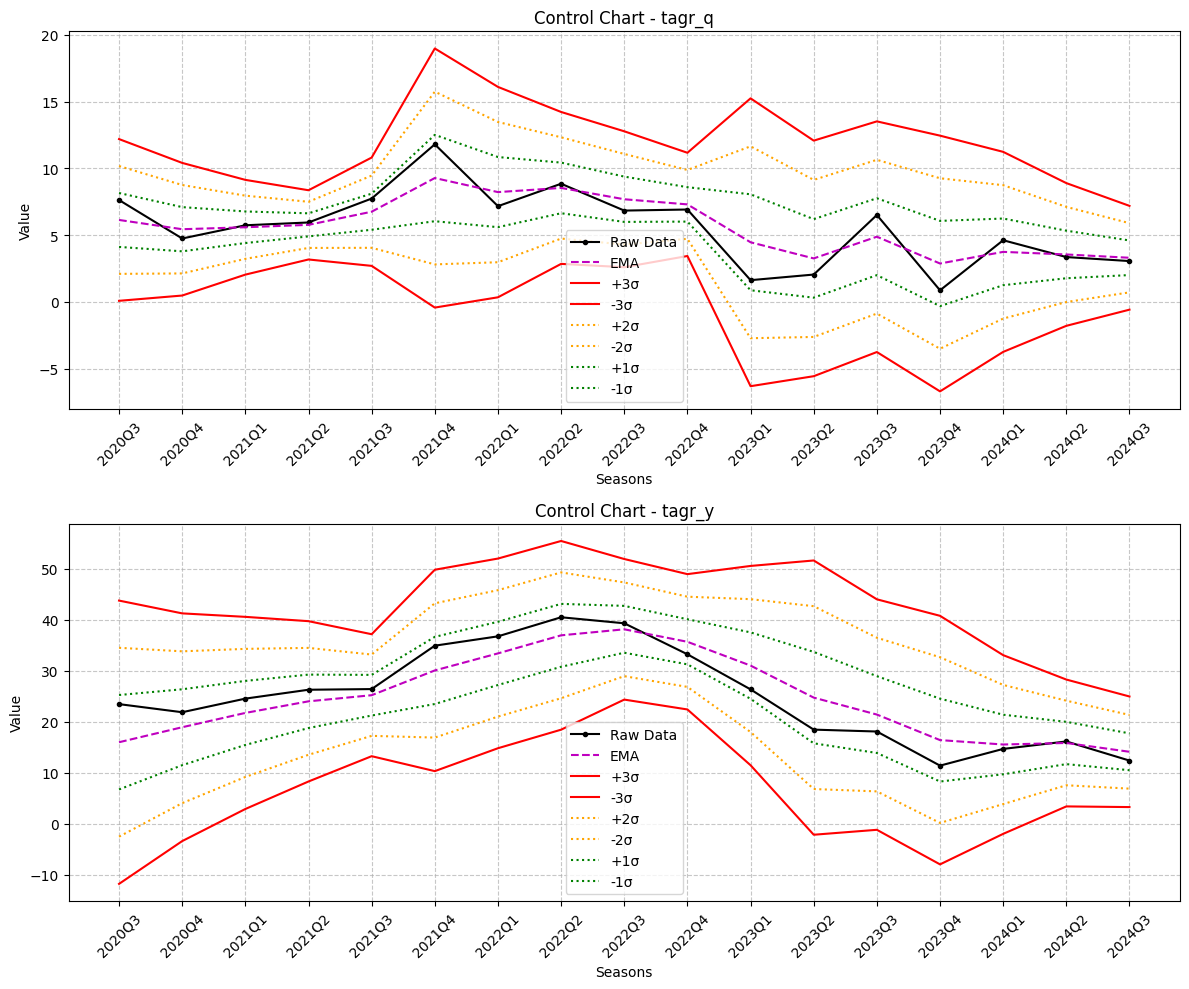

{'tagr_q': [{'seasons': '2020Q3', 'tagr_q': 7.63, 'ema': 6.13875, 'emsd': 2.018433503864769, 'UCL_1sigma': 8.157183503864768, 'LCL_1sigma': 4.120316496135231, 'UCL_2sigma': 10.175617007729539, 'LCL_2sigma': 2.101882992270462, 'UCL_3sigma': 12.194050511594307, 'LCL_3sigma': 0.08344948840569266}, {'seasons': '2020Q4', 'tagr_q': 4.75, 'ema': 5.444375, 'emsd': 1.6550356313918049, 'UCL_1sigma': 7.099410631391805, 'LCL_1sigma': 3.789339368608195, 'UCL_2sigma': 8.75444626278361, 'LCL_2sigma': 2.13430373721639, 'UCL_3sigma': 10.409481894175414, 'LCL_3sigma': 0.4792681058245849}, {'seasons': '2021Q1', 'tagr_q': 5.74, 'ema': 5.5921875, 'emsd': 1.1825227146547699, 'UCL_1sigma': 6.774710214654769, 'LCL_1sigma': 4.40966478534523, 'UCL_2sigma': 7.957232929309539, 'LCL_2sigma': 3.22714207069046, 'UCL_3sigma': 9.13975564396431, 'LCL_3sigma': 2.04461935603569}, {'seasons': '2021Q2', 'tagr_q': 5.95, 'ema': 5.77109375, 'emsd': 0.8641126427385838, 'UCL_1sigma': 6.635206392738584, 'LCL_1sigma': 4.906981107

In [104]:
if __name__ == '__main__':    
   control_charts_reports = create_control_charts([{"seasons": "202403", "tagr_q": 34264319, "tagr_y":2}])
   plot_control_chart(control_charts_reports)
   print(control_charts_reports)